[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Gaussian Probabilities

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style, set_figsize, figsize
load_style()

## Introduction

The last chapter ended by discussing some of the drawbacks of the Discrete Bayesian filter. For many tracking and filtering problems our desire is to have a filter that is *unimodal* and *continuous*. That is, we want to model our system using floating point math (continuous) and to have only one belief represented (unimodal). For example, we want to say an aircraft is at (12.34, -95.54, 2389.5) where that is latitude, longitude, and altitude. We do not want our filter to tell us "it *might be* at (1.65, -78.01, 2100.45) or it *might be* at (34.36, -98.23, 2543.79)." That doesn't match our physical intuition of how the world works, and as we discussed, it can be prohibitively expensive to compute the multimodal case. 

>So we desire a unimodal, continuous way to represent probabilities that models how the real world works, and that is very computationally efficient to calculate. As you might guess from the chapter name, Gaussian distributions provide all of these features.

## Mean, Variance, and Standard Deviations

### Random Variables

To understand Gaussians we first need to understand a few simple mathematical definitions and computations.

To understand Gaussians we first need to understand a few simple mathematical computations. We start with a *random variable* x. Maybe x is the height of the students in a class in meters. We call $x$ *random* because the height of one student does not depend on the height of another student - each is independent. For a specific classrom perhaps the heights are

$$x= [1.8, 2.0, 1.7, 1.9, 1.6]$$

Another example of a random variable would be the result of a coin toss. Each coin toss is independent from all other tosses. Rolling a die would be another example of a random variable.

The coin toss and die roll are examples of *discrete random variables*. That is, the outcome of any given event comes from a discrete set of values. The roll of a six sided die can never produce a value of 7 or 3.24, for example. In contrast, the student heights are continuous; they can take on any value (within biological limits, naturally). For example, heights of 1.7, 1.71, 1.711, 1.7111, 1.71111,.... are all possible. Do not confuse the *measurement* of the random variable with the actual value. If we can only measure the height of a person to 0.1 meters we would only record values from 0.1, 0.2, 0.3...2.7, or 27 discrete choices. Nonetheless the heights can vary between any arbitrary real value between those ranges, and so it is continuous. 

### The Mean of a Random Variable

We want to know the *average* height of the students. Another word for *average* is the *mean*.  We compute the mean by summing the values and dividing by the number of values. In this case we have

$$mean = (1.8 + 2.0 + 1.7 + 1.9 + 1.6)/5 = 1.8$$

In statistics we normally use the symbol $\mu$ to denote the mean, so we could write 

$$\mu_x = 1.8$$

where the subscript *x* denotes that this is the mean for the vector $\mathbf{x}$. We can formalize this computation with the equation

$$ \mu_x = \frac{1}{n}\sum^n_{i=1} x_i$$

NumPy has the function `numpy.mean()` which computes the mean for you.

In [2]:
import numpy as np

x = [1.8, 2.0, 1.7, 1.9, 1.6]
print(np.mean(x))

1.8


### Standard Deviation of a Random Variable

The computation above tells us the average height of the students, but it doesn't tell us everything we might want to know. For example, suppose a second class has students with these heights:

$$y = [2.2, 1.5, 2.3, 1.7, 1.3]$$

In [3]:
y = [2.2, 1.5, 2.3, 1.7, 1.3]
np.mean(y)

1.8

the mean of these heights is also 1.8 m, but notice that there is a much greater amount of variation in the heights in this class. Finally, suppose a third class has heights

$$ z = [1.8, 1.8, 1.8, 1.8, 1.8]$$

In this third class the average height is again 1.8 m, but here there is no variation in the height between students at all.

We want to be able to specify how much *variation* there is between the heights of the students. You can imagine a number of reasons for this. Perhaps a school district needs to order 5,000 desks, and they want to be sure they buy sizes that accommodate the range of heights of the students. 

Statistics has formalized this concept of measuring variation into the notion of *standard deviation* and *variance*:

**The standard deviation is defined as the square root of the average of the squared differences from the mean.**

That's a mouthful; as an equation this is stated as

$$\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^N(x_i - \mu)^2}$$

where $\sigma$ is the notation for the standard deviation.


If this is the first time you have seen this it may not have a lot of meaning for you. But let's just work through that with the data from three classes to be sure we understand the formula. We just subtract the mean of x from each value of x, square it, take the average of those, and then take the square root of the result.  The mean of $[1.8, 2.0, 1.7, 1.9, 1.6]$ is 1.8, so we compute the standard deviation as

$$ 
\begin{aligned}
\sigma_x &=\sqrt{\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5}} \\
&= \sqrt{\frac{0^2 + 0.2^2 + (-0.1)^2 + 0.1^2 + (-0.2)^2}{5}} \\
&= \sqrt{\frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5}} \\
&= \sqrt{0.02} \\
\sigma_x&= 0.1414
\end{aligned}$$

We use the symbol $\sigma$ to denote the standard deviation.

We can verify this computation with the NumPy method `std()` which computes the standard deviation.

In [4]:
print('{:.4f}'.format(np.std(x)))

0.1414


What does this number *mean* (no pun intended)? *How much* in "how much do the heights vary" is not a mathematical term. We will be able to define it much more precisely once we introduce the concept of a Gaussian in the next section. For now I'll say that for many things in nature, including the height of people, 68% of all values lie within one standard deviation of the mean. In other words we can conclude that for a random class 68% of the students will have heights between 1.66 (1.8-0.1414) meters and 1.94 (1.8+0.1414) meters. 

We can look at this in a plot:

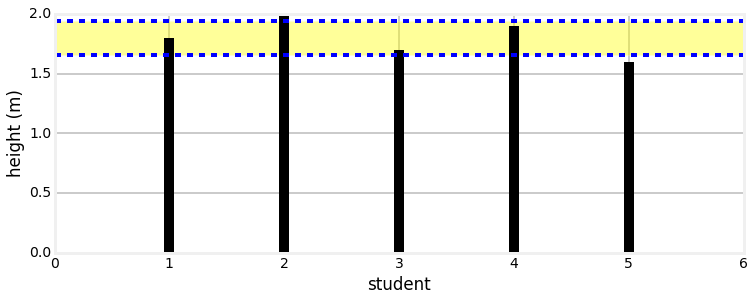

In [5]:
import matplotlib.pyplot as plt

def plot_height_std(x, lw=10):
    m = np.mean(x)
    s = np.std(x)

    for i, height in enumerate(x):
        plt.plot([i+1, i+1], [0, height], color='k', lw=lw)
    plt.xlim(0,len(x)+1)
    plt.axhline(m-s, ls='--')
    plt.axhline(m+s, ls='--')
    plt.fill_between((0, len(x)+1), m-s, m+s, 
                     facecolor='yellow', alpha=0.4)
    plt.xlabel('student')
    plt.ylabel('height (m)')
    plt.show()
    
x= [1.8, 2.0, 1.7, 1.9, 1.6]
plot_height_std(x)

For only 5 students we obviously will not get exactly 68% within one standard deviation (normally denoted as $1\sigma$), but we do see that 3 out of 5 students are within $1\sigma$, or 60%, which is as close as you can get to 68% with only 5 samples. I haven't yet introduced enough math or Python for you to fully understand the next bit of code, but let's look at the results for a class with 100 students.

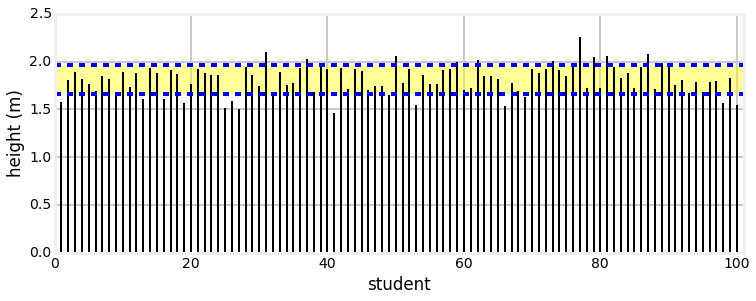

mean of x = 1.814
std of x = 0.149


In [6]:
from numpy.random import randn
x = [1.8 + .1414*randn() for i in range(100)]
plot_height_std(x, lw=2)

print('mean of x = {:.3f}'.format(np.mean(x)))
print('std of x = {:.3f}'.format(np.std(x)))

We can see by eye that roughly 68% of the heights lie within $1\sigma$ of the mean 1.8.

We'll discuss this in greater depth soon. For now let's compute the standard deviation for 

$$y = [2.2, 1.5, 2.3, 1.7, 1.3]$$

The mean of y is $\mu=1.8$ m, so 
$$ 
\begin{aligned}
\sigma_y &=\sqrt{\frac{(2.2-1.8)^2 + (1.5-1.8)^2 + (2.3-1.8)^2 + (1.7-1.8)^2 + (1.3-1.8)^2} {5}} \\
&= \sqrt{\frac{0.4^2 + (-0.3)^2 + 0.5^2 + (-0.1)^2 + (-0.5)^2}{5}} \\
&= \sqrt{\frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5}} \\
&= \sqrt{0.152} \\
\sigma_y&= 0.39 \ m
\end{aligned}$$

We will verify that with NumPy with

In [7]:
print('{:.4f} m'.format(np.std(y)))

0.3899 m


This corresponds with what we would expect. There is more variation in the heights for y, and the standard deviation is larger.

Finally, let's compute the standard deviation for 

$$ z = [1.8, 1.8, 1.8, 1.8, 1.8]$$

There is no variation in the values, so we would expect the standard deviation to be zero. We show this to be true with

$$ 
\begin{aligned}
\sigma_z &=\sqrt{\frac{(1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (183-1.8)^2} {5}} \\
&= \sqrt{\frac{0+0+0+0+0}{5}} \\
\sigma_Z&= 0.0 \ m
\end{aligned}$$

### Variance of a Random Variable
Finally, the *variance* is defined as the square of the standard deviation. Some texts define this in the opposite way, which gives the definitions

* **The variance is the average of the squared differences from the mean.**

* **The standard deviation is the square root of the variance.**

Both ways of thinking about it are equivalent. We use the notation $\sigma^2$ for the variance, and the equation for the variance is


$$\sigma^2 = \frac{1}{N}\sum_{i=1}^N(x_i - \mu)^2$$


To make sure we understand this let's compute the variance for $x$:

$$ 
\begin{aligned}
\sigma_x^2 &=\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5} \\
&= \frac{0^2 + 0.2^2 + (-0.1)^2 + 0.1^2 + (-0.2)^2}{5} \\
&= \frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5} \\
&=0.02
\end{aligned}$$

We previously computed $\sigma_x=0.1414$, and indeed the square of 0.1414 is 0.02. We can verify this computation with the NumPy function `numpy.var`:

In [8]:
print('VAR(x) = {:.2f} m'.format(np.var(x)))

VAR(x) = 0.02 m


Many texts alternatively use *VAR(x)* to denote the variance of x, and I opted to use that here just to expose you to that convention.

### Why the Square of the Differences

As an aside, why are we taking the *square* of the difference? I could go into a lot of math, but let's just look at this in a simple way. Here is a chart of the values of x plotted against the mean for $x=[3,-3,3,-3]$


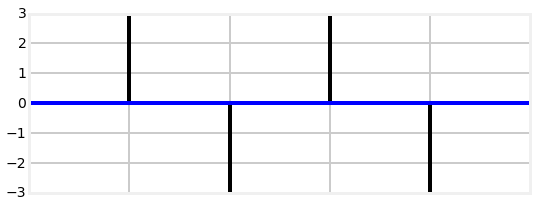

In [9]:
with figsize(8, 3):
    x = [3, -3, 3, -3]
    m = np.average(x)
    for i in range(len(x)):
        plt.plot([i ,i], [m, x[i]], color='k')
    plt.axhline(m)
    plt.xlim(-1, len(x))
    plt.tick_params(axis='x', labelbottom='off')
    plt.show()

If we didn't take the square of the differences the signs would cancel everything out:

$$\frac{(3-0) + (-3-0) + (3-0) + (-3-0)}{4} = 0$$

This is clearly incorrect, as there is more than 0 variance in the data. 

Maybe we can use the absolute value? We can see by inspection that the result is $12/4=3$ which is certainly correct - each value varies by 3 from the mean. But what if we change $x=[6, -2, -3, 1]$? In this case we get $12/4=3$. $x$ is clearly more spread out than in the last example, but we get the same variance, so this cannot be correct. If we use the correct formula we get a variance of 3.5, which correctly reflects the larger variatin in $x$.

This is clearly not a proof of correctness; indeed, Gauss recognized that is is somewhat arbitrary. If the variable is distributed normally we can prove that the variance is computed by this function. If there are outliers, meaning values that are not normally distributed, than squaring the difference gives disproportinate weight to that term. For example, let's see what happens if we have $x = [1,-1,1,-2,3,2,100]$. I'll use NumPy's `var()` method to compute the variance for me.

In [10]:
x = [1, -1, 1, -2, 3, 2, 100]
print('Variance of x = {:.2f}'.format(np.var(x)))

Variance of x = 1210.69


Is this *correct*? You tell me. Without the outlier of 100 we get $\sigma^2=2.89$, which accurately reflects how $x$ absent the outlier is varying. The one outlier swamps the computation. I will not continue down this path; if you are interested you might want to look at the work that James Berger has done on this problem. For Kalman filters, which assume Gaussian distributions, we can prove that squaring the terms produces optimal results. More about that soon.

## Gaussians

We are now ready to learn about Gaussians. Let's remind ourselves of the motivation for this chapter.

>We desire a unimodal, continuous way to represent probabilities that models how the real world works, and that is very computationally efficient to calculate.

Before we go into the math, lets just look at a graph of a Gaussian distribution to get a sense of what we are talking about.

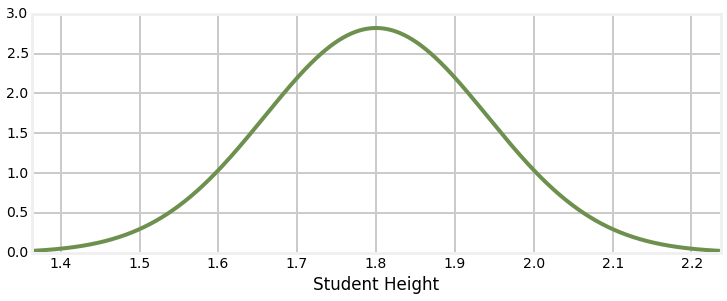

In [11]:
from stats import plot_gaussian

plot_gaussian(mean=1.8, variance=0.1414**2, xlabel='Student Height')

Probably this is immediately recognizable to you as a 'bell curve'. This curve is ubiquitous because under real world conditions most observations are distributed in such a manner. In fact, this is the bell curve the student heights given earlier. 

This curve is not unique to heights - a vast amount of natural phenomena exhibits this sort of distribution, including the sensors that we use in filtering problems. As we will see, it also has all the attributes that we are looking for - it represents a unimodal belief or value as a probability, it is continuous, and it is computationally efficient. We will soon discover that it also other desirable qualities that we do not yet recognize we need.

## Nomenclature

A bit of nomenclature before we continue - this chart depicts the *probability density* of of a *random variable* having any value between ($-\infty..\infty)$. What does that mean? Imagine we take an infinite number of infinitely precise measurements of the speed of automobiles on a section of highway. We could then plot the results by showing the relative number of cars going at any given speed. If the average was 120 kph, it might look like this:

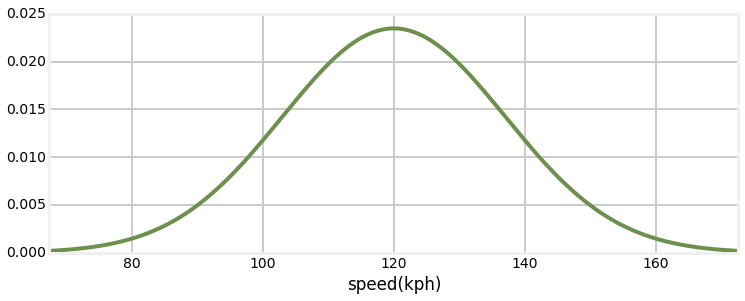

In [12]:
plot_gaussian(mean=120, variance=17**2, xlabel='speed(kph)')

The y-axis depicts the *probability density* - the relative amount of cars that are going the speed at the corresponding x-axis.

You may object that human heights or automobile speeds cannot be less than zero, let alone $-\infty$. This is true, but this is a common limitation of mathematical modeling. "The map is not the territory" is a common expression, and it is true for Bayesian filtering and statistics. The Gaussian distribution above very closely models the distribution of the measured automobile speeds, but being a model it is necessarily imperfect. The difference between model and reality will come up again and again in these filters. 

You will see these distributions called *Gaussian distributions*, *normal distributions*, and *bell curves*. Bell curve is ambiguous because there are other distributions which also look bell shaped but are not Gaussian distributions, so we will not use it further in this book. But *Gaussian* and *normal* both mean the same thing, and are used interchangeably. I will use both throughout this book as different sources will use either term, and so I want you to be used to seeing both. Finally, as in this paragraph, it is typical to shorten the name and just talk about a *Gaussian* or *normal* - these are both typical shortcut names for the *Gaussian distribution*. 

## Gaussian Distributions

So let us explore how Gaussians work. A Gaussian is a *continuous probability distribution* that is completely described with two parameters, the mean ($\mu$) and the variance ($\sigma^2$). It is defined as:
$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}{(x-\mu)^2}/\sigma^2 }
$$

<p> Don't be dissuaded by the equation if you haven't seen it before; you will not need to memorize or manipulate it. The computation of this function is stored in `stats.py` with the function `gaussian(x, mean, var)`.

> **Optional:** Let's remind ourselves how to look at a function stored in a file by using the *%load* magic. If you type *%load -s gaussian stats.py* into a code cell and then press CTRL-Enter, the notebook will create a new input cell and load the function into it.

    %load -s gaussian stats.py
    
    def gaussian(x, mean, var):
        """returns normal distribution for x given a 
        gaussian with the specified mean and variance. 
        """
        return np.exp((-0.5*(x-mean)**2)/var) / \
                         np.sqrt(_two_pi*var)

<p><p><p><p>We will plot a Gaussian with a mean of 22 $(\mu=22)$, with a variance of 4 $(\sigma^2=4)$, and then discuss what this means. 

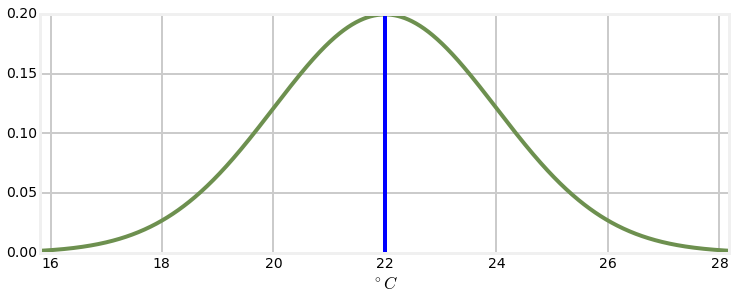

In [13]:
from stats import gaussian, norm_cdf
plot_gaussian(22, 4, mean_line=True, xlabel='$^{\circ}C$')

So what does this curve *mean*? Assume for a moment that we have a thermometer, which reads 22$\,^{\circ}C$. No thermometer is perfectly accurate, and so we normally expect that thermometer will read $\pm$ that temperature by some amount each time we read it. Furthermore, a theorem called  **Central Limit Theorem** states that if we make many measurements that the measurements will be normally distributed. So, when we look at this chart we can *sort of* think of it as representing the probability of the thermometer reading a particular value given the actual temperature of 22$^{\circ}C$. However, that is not quite accurate mathematically. 

Recall that we said that the distribution is *continuous*. Think of an infinitely long straight line - what is the probability that a point you pick randomly is at, say, 2.0. Clearly 0%, as there is an infinite number of choices to choose from. The same is true for normal distributions; in the graph above the probability of being *exactly* 22$^{\circ}C$ is 0% because there are an infinite number of values the reading can take.

So what then is this curve? It is something we call the *probability density function.* Later we will delve into this in greater detail; for now just understand that the area under the curve at any region gives you the probability of those values. So, for example, if you compute the area under the curve between 20 and 22 the result will be the probability of the temperature reading being between those two temperatures.

So how do you compute the probability, or area under the curve? Well, you integrate the equation for the Gaussian 

$$ \int^{x_1}_{x_0}  \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}{(x-\mu)^2}/\sigma^2 } dx$$

I wrote `stats.norm_cdf` which computes the integral for you. So, for example, we can compute

In [14]:
print('Probability of value in range 21.5 to 22.5 is {:.2f}%'.format(
      norm_cdf((21.5, 22.5), 22,4)*100))
print('Probability of value in range 23.5 to 24.5 is {:.2f}%'.format(
      norm_cdf((23.5, 24.5), 22,4)*100))

Probability of value in range 21.5 to 22.5 is 19.74%
Probability of value in range 23.5 to 24.5 is 12.10%


So the mean ($\mu$) is what it sounds like - the average of all possible probabilities. Because of the symmetric shape of the curve it is also the tallest part of the curve. The thermometer reads $22^{\circ}C$, so that is what we used for the mean.  

> *Important*: I will repeat what I wrote at the top of this section: "A Gaussian...is completely described with two parameters"

The standard notation for a normal distribution for a random variable $X$ is $X \sim\ \mathcal{N}(\mu,\sigma^2)$. This means I can express the temperature reading of our thermometer as

$$temp = \mathcal{N}(22,4)$$

This is an **extremely important** result. Gaussians allow me to capture an infinite number of possible values with only two numbers! With the values $\mu=22$ and $\sigma^2=4$ I can compute the distribution of measurements for over any range.

## The Variance

Since this is a probability density distribution it is required that the area under the curve always equals one. This should be intuitively clear - the area under the curve represents all possible occurrences, which must sum to one. We can prove this ourselves with a bit of code. (If you are mathematically inclined, integrate the Gaussian equation from $-\infty$ to $\infty$)

In [15]:
print(norm_cdf((-1e8, 1e8), mu=0, var=4))

1.0


This leads to an important insight. If the variance is small the curve will be narrow. this is because the variance is a measure of *how much* the samples vary from the mean. To keep the area equal to 1, the curve must also be tall. On the other hand if the variance is large the curve will be wide, and thus it will also have to be short to make the area equal to 1.

Let's look at that graphically:

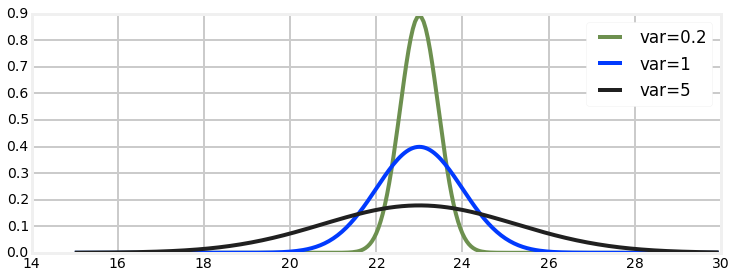

In [16]:
import numpy as np
import matplotlib.pyplot as plt
    
xs = np.arange(15, 30, 0.05)
plt.plot(xs, gaussian(xs, 23, 0.2), label='var=0.2')
plt.plot(xs, gaussian(xs, 23, 1), label='var=1')
plt.plot(xs, gaussian(xs, 23, 5), label='var=5')
plt.legend()
plt.show()

So what is this telling us? The blue gaussian is very narrow. It is saying that we believe $x=23$, and that we are very sure about that. In contrast, the red gaussian also believes that $x=23$, but we are much less sure about that. Our believe that $x=23$ is lower, and so our belief about the likely possible values for $x$ is spread out - we think it is quite likely that $x=20$ or $x=26$, for example. The blue gaussian has almost completely eliminated $22$ or $24$ as possible value - their probability is almost $0\%$, whereas the red curve considers them nearly as likely as $23$.

If we think back to the thermometer, we can consider these three curves as representing the readings from three different thermometers. The blue curve represents a very accurate thermometer, and the black one represents a fairly inaccurate one. Green of course represents one in between the two others. Note the very powerful property the Gaussian distribution affords us - we can entirely represent both the reading and the error of a thermometer with only two numbers - the mean and the variance.

It is worth spending a few words on standard deviation now. The standard deviation is a measure of how much variation from the mean exists. For Gaussian distributions, 68% of all the data falls within one standard deviation($1\sigma$) of the mean, 95% falls within two standard deviations ($2\sigma$), and 99.7% within three ($3\sigma$). This is often called the 68-95-99.7 rule. So if you were told that the average test score in a class was 71 with a standard deviation of 9.4, you could conclude that 95% of the students received a score between 52.2 and 89.8 if the distribution is normal (that is calculated with $71 \pm (2 * 9.4)$). 

The following graph depicts the relationship between the standard deviation and the normal distribution. 

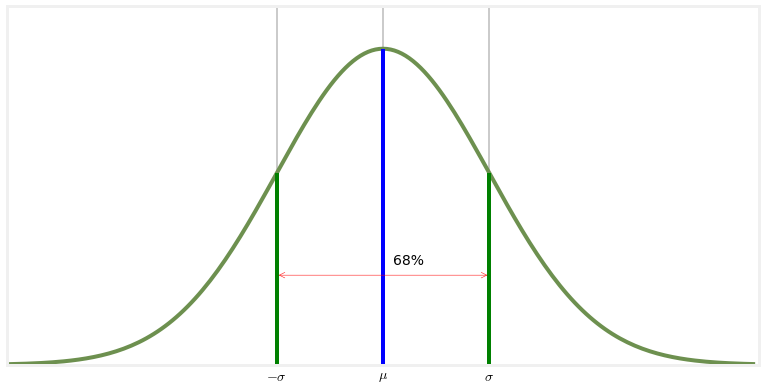

In [17]:
from gaussian_internal import display_stddev_plot
display_stddev_plot()
plt.show()

> An equivalent formation for a Gaussian is $\mathcal{N}(\mu,1/\tau)$ where $\mu$ is the *mean* and $tau$ the *precision*. Here $1/\tau = \sigma^2$; it is the reciprocal of the variance. While we do not use this formulation in this book, it underscores that the variance is a measure of how precise our data is. A small variance yields large precision - our measurement is very precise. Conversely, a large variance yields low precision - our belief is spread out across a large area. You should become comfortable with thinking about Gaussians in these equivalent forms. Gaussians reflect our *belief* about a measurement, they express the *precision* of the measurement, and they express how much *variance* there is in the measurements. These are all different ways of stating the same fact.</div>

## Interactive Gaussians

For those that are reading this in IPython Notebook, here is an interactive version of the Gaussian plots. Use the sliders to modify $\mu$ and $\sigma^2$. Adjusting $\mu$ will move the graph to the left and right because you are adjusting the mean, and adjusting $\sigma^2$ will make the bell curve thicker and thinner.

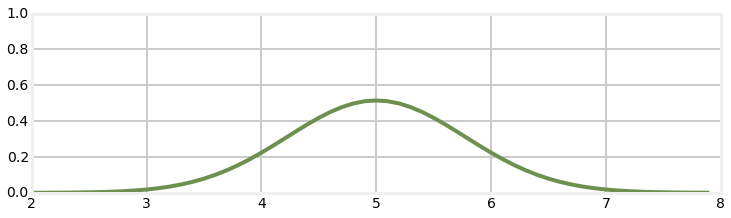

In [18]:
import math
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets

set_figsize(y=3)
def plt_g(mu,variance):
    xs = np.arange(2, 8, 0.1)
    ys = gaussian(xs, mu, variance)
    plt.plot(xs, ys)
    plt.ylim((0, 1))
    plt.show()

interact (plt_g, mu=(0, 10), 
          variance=widgets.FloatSliderWidget(value=0.6, min=0.2, max=4));

Finally, if you are reading this in an IPython Notebook, here is an animation of a Gaussian. First, the mean is being shifted to the right. Then the mean is centered at $\mu=5$ and the variance is modified.

<img src='animations/04_gaussian_animate.gif'>

## Plotting Exponentials (Optional)

Where does the shape of the Gaussian come from? Recall the equation for the Gaussian:

$$ f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}{(x-\mu)^2}/\sigma^2 }$$

$\mu$ and $\sigma$ are constants, so a simplified form of this equation is

$$ 
f(x, \mu, \sigma) = c_1 * e^{-c_2{(x-\mu)^2} }
$$

Let's just simplify it further by assuming the constants are one(not true for Gaussians, but the general shape will be the same) and the mean is zero.

$$ 
f(x)=e^{-x^2}
$$

Raising a value to a negative power is the same as the reciprocal of the value raised to a positive power. I.e.

$$e^{-x^2} = \frac{1}{e^{x^2}}$$


Let's plot this in stages. Here is $e^{x^2}$.

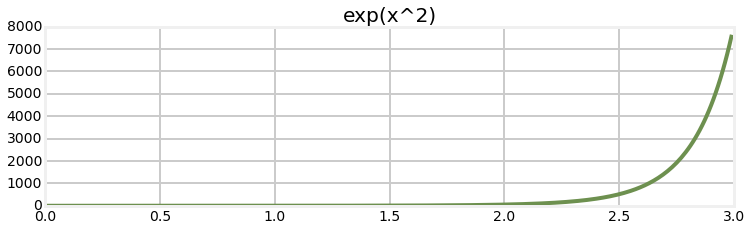

In [19]:
x = np.arange(0, 3, 0.01)
plt.plot(x, np.exp(x**2))
plt.title('exp(x^2)')
plt.show()

As x gets larger the value of $e^{x^2}$ grows exponentially (hence the name *exponential function*). If we take the reciprocal of a rapidly increasing number the result should approach, but never reach 0.

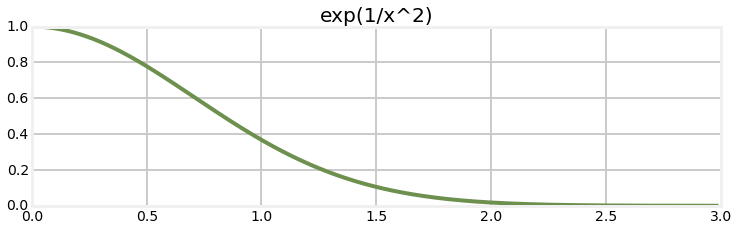

In [20]:
plt.plot(x, 1/np.exp(x**2))
plt.title('exp(1/x^2)')
plt.show()

We know that $1/e^x = e^{-x}$, so we can equivalently calculate

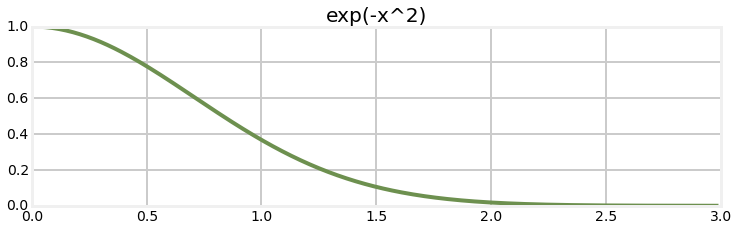

In [21]:
plt.plot(x, np.exp(-x**2))
plt.title('exp(-x^2)')
plt.show()

The final piece of the puzzle is to plot the values for -x as well.

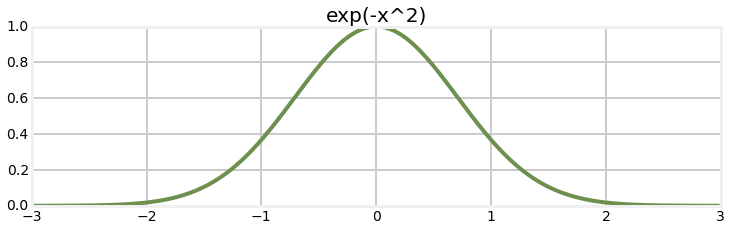

In [22]:
x = np.arange(-3, 3, 0.01)
plt.plot(x, np.exp(-x**2))
plt.title('exp(-x^2)')
plt.show()

And with this we have the shape of the Gaussian. The Gaussian equation has different constants, and hence a somewhat different shape, but both are 'bell curves', as seen below.

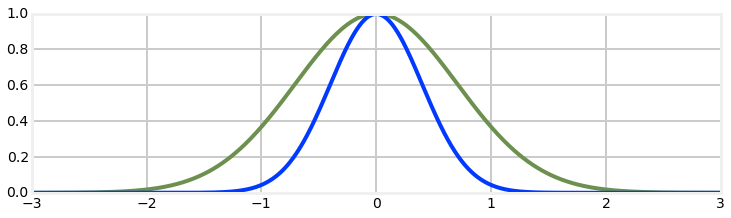

In [23]:
x = np.arange(-3, 3, 0.01)
plt.plot(x, np.exp(-x**2))
plot_gaussian(mean=0, variance=0.16, xlim=(-3,3))

## Computational Properties of the Gaussian

Recall how our discrete Bayesian filter worked. We had a vector implemented as a NumPy array representing our belief at a certain moment in time. When we performed another measurement using the `update()` function we had to multiply probabilities together, and when we performed the motion step using the `predict()` function we had to shift and add probabilities. I've promised you that the Kalman filter uses essentially the same process, and that  it uses Gaussians instead of histograms, so you might reasonable expect that we will be multiplying, adding, and shifting Gaussians in the Kalman filter.

A typical textbook would directly launch into a multi-page proof of the behavior of Gaussians under these operations, but I don't see the value in that right now. I think the math will be much more intuitive and clear if we just start developing a Kalman filter using Gaussians. I will provide the equations for multiplying and shifting Gaussians at the appropriate time. You will then be able to develop a physical intuition for what these operations do, rather than be forced to digest a lot of fairly abstract math.

The key point, which I will only assert for now, is that all the operations are very simple, and that they preserve the properties of the Gaussian. This is somewhat remarkable, in that the Gaussian is a nonlinear function, and typically if you multiply a nonlinear equation with itself you end up with a different equation. For example, the shape of `sin(x)sin(x)` is very different from `sin(x)`. But the result of multiplying two Gaussians is yet another Gaussian. This is a fundamental property, and a key reason why Kalman filters are computationally feasible.

## Computing Probabilities with scipy.stats

In this chapter I have used custom code for computing Gaussians, plotting, and so on. I chose to do that to give you a chance to look at the code and see how these functions are implemented.  However, Python comes with "batteries included" as the saying goes, and it comes with a wide range of statistics functions in the module `scipy.stats`. I find the performance of some of the functions rather slow (the scipy.stats documentation contains a warning to this effect), but this is offset by the fact that this is standard code available to everyone, and it is well tested. So let's walk through how to use scipy.stats to compute various things.

The scipy.stats module contains a number of objects which you can use to compute attributes of various probability distributions. The full documentation for this module is here: http://http://docs.scipy.org/doc/scipy/reference/stats.html. However, we will focus on the  norm variable, which implements the normal distribution. Let's look at some code that uses `scipy.stats.norm` to compute a Gaussian, and compare its value to the value returned by the `gaussian()` function.

In [24]:
from scipy.stats import norm
print(norm(2, 3).pdf(1.5))
print(gaussian(x=1.5, mean=2, var=3*3))

0.131146572034
0.131146572034


The call `norm(2, 3)` creates what scipy calls a 'frozen' distribution - it creates and returns an object with a mean of 2 and a standard deviation of 3. You can then use this object multiple times to get the probability density of various values, like so:

In [25]:
n23 = norm(2, 3)
print('probability density of 1.5 is %.4f' % n23.pdf(1.5))
print('probability density of 2.5 is also %.4f' % n23.pdf(2.5))
print('whereas probability density of 2 is %.4f' % n23.pdf(2))

probability density of 1.5 is 0.1311
probability density of 2.5 is also 0.1311
whereas probability density of 2 is 0.1330


If we look at the documentation for `scipy.stats.norm` <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.normfor">here</a>[1] we see that there are many other functions that norm provides.

For example, we can generate $n$ samples from the distribution with the `rvs()` function.

In [26]:
print(n23.rvs(size=15))

[-4.9319185   7.42717614  0.30516886  2.03820093 -0.53279301  1.47342206
  5.15956672 -4.8098251   0.65236831  2.08959498  0.63100735  2.53347798
  4.67320124  0.65275885 -0.9319758 ]


We can get the *cumulative distribution function (CDF)*, which is the probability that a randomly drawn value from the distribution is less than or equal to $x$.

In [27]:
# probability that a random value is less than the mean 2
print(n23.cdf(2))

0.5


We can get various properties of the distribution:

In [28]:
print('variance is', n23.var())
print('standard deviation is', n23.std())
print('mean is', n23.mean())

variance is 9.0
standard deviation is 3.0
mean is 2.0


There are many other functions available, and if you are interested I urge you to peruse the documentation. I find the documentation to be excessively terse, but with a bit of googling you can find out what a function does and some examples of how to use it. Most of this functionality is not of immediate interest to the book, so I will leave the topic in your hands to explore. The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">SciPy tutorial</a> [2] is quite approachable, and I suggest starting there. 

## Fat Tails

Earlier I spoke very briefly about the *central limit theorem*, which states that under certain conditions the arithmetic sum of **any** independent random variables will be normally distributed, regardless of how the random variables are distributed. This is extremely important for (at least) two reasons. First, nature is full of distributions which are not normal, but when we apply the central limit theorem over large populations we end up with normal distributions. Second, Gaussians are mathematically *tractable*. We will see this more as we develop the Kalman filter theory, but there are very nice closed form solutions for operations on Gaussians that allow us to use them analytically.

However, a key part of the proof is "under certain conditions". These conditions often do not hold for the physical world. The resulting distributions are called *fat tailed*. Let's consider a trivial example. We think of things like test scores as being normally distributed. If you have ever had a professor 'grade on a curve' you have been subject to this assumption. But of course test scores cannot follow a normal distribution. This is because the distribution assigns a nonzero probability distribution for *any* value, no matter how far from the mean. So, for example, say your mean is 90 and the standard deviation is 13. The normal distribution assumes that there is a large chance of somebody getting a 90, and a small chance of somebody getting a 40. However, it also implies that there is a tiny chance of somebody getting a -10, or of 150. It assumes that there is a infinitesimal chance of getting a score of -1e300, or 4e50. In other words, the *tails* of the distribution are infinite. 

But for a test we know this is not true. You cannot get less than 0, or more than 100. Let's plot this using a normal distribution.

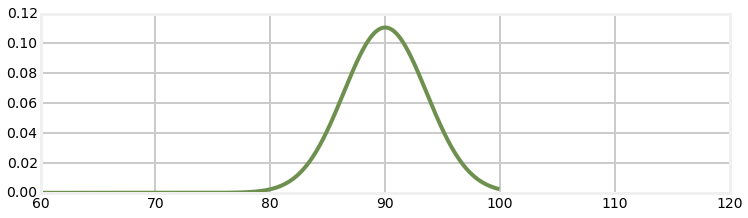

In [29]:
xs = np.arange(10,100, 0.05)
plt.plot(xs, [gaussian(x, 90, 13) for x in xs], label='var=0.2')
plt.xlim((60,120))
plt.show()

So the problem with this chart is that the area under the drawn curve cannot equal 1, so it is not a probability distribution. What actually happens is that a few more students get scores nearer the upper end of the range (for example), and that tail becomes 'fat'. Also, the test is probably not able to perfectly distinguish incredibly minute differences in skill in the students, so the distribution to the left of the mean is also probably a bit bunched up in places. The resulting distribution is called a *fat tail distribution*.

We are not going to be applying Kalman filters to grades of student papers, but we are using physical sensors to measure the world. The errors in sensor's measurements are rarely truly Gaussian. And, of course, the signal itself will have time dependent correlations. For example, consider a sensor mounted on a helicopter. The rotating blades cause vibrations in the air frame, which will cause small deviations in the flight path. This deviation will be related to the frequency of the vibration, hence the values at t and t+1 are not *independent*. The vibration will effect sensors such as the INS. No physical object can react instantly to changes, so the INS will somewhat lag the vibrations in a perhaps quite complex way, and so the noise introduced by the vibration will be anything but independent. 

It is far too early to be talking about the difficulties that this presents to the Kalman filter designer. It is worth keeping in the back of your mind the fact that the Kalman filter math is based on a somewhat idealized model of the world.  For now I will present a bit of code that I will be using later in the book to form fat tail distributions to simulate various processes and sensors. This distribution is called the student's t distribution. 

Let's say I want to model a sensor that has some noise in the output. For simplicity, let's say the signal is a constant 10, and the standard deviation of the noise is 2. We can use the function `numpy.random.randn()` to get a random number with a mean of 0 and a standard deviation of 1. So I could simulate this sensor with

In [30]:
from numpy.random import randn

def sense():
    return 10 + randn()*2

Let's plot that signal and see what it looks like.

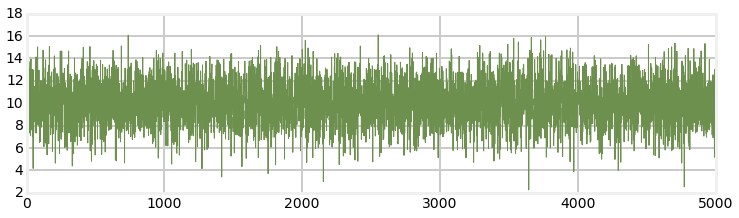

In [31]:
zs = [sense() for i in range(5000)]
plt.plot(zs, lw=1)
plt.show()

That looks like I would expect. The signal is centered around 10. A standard deviation of 2 means that 68% of the measurements will be within $\pm$ 2 of 10, and 99% will be within $\pm$ 6 of 10, and that looks like what is happening. 

Now let's look at a fat tailed distribution. There are many choices, I will use the Student's T distribution. I will not go into the math, but just give you the source code for it and then plot a distribution using it.

In [32]:
import random
import math

def rand_student_t(df, mu=0, std=1):
    """return random number distributed by student's t distribution with
    `df` degrees of freedom with the specified mean and standard deviation.
    """
    x = random.gauss(0, std)
    y = 2.0*random.gammavariate(0.5*df, 2.0)
    return x / (math.sqrt(y / df)) + mu

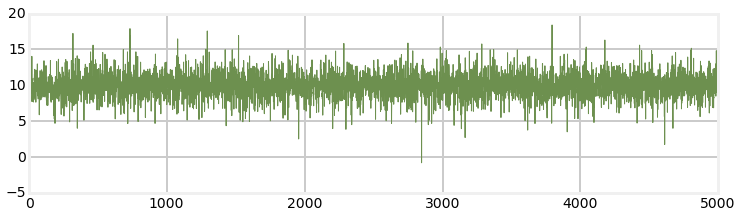

In [33]:
def sense_t():
    return 10 + rand_student_t(7)*2

zs = [sense_t() for i in range(5000)]
plt.plot(zs, lw=1)
plt.show()

We can see from the plot that while the output is similar to the normal distribution there are outliers that go far more than 3 standard deviations from the mean. This is what causes the 'fat tail'.

It is unlikely that the Student's T distribution is an accurate model of how your sensor (say, a GPS or Doppler) performs, and this is not a book on how to model physical systems. However, it does produce reasonable data to test your filter's performance when presented with real world noise. We will be using distributions like these throughout the rest of the book in our simulations and tests. 

This is not an idle concern. The Kalman filter equations assume the noise is normally distributed, and perform sub-optimally if this is not true. Designers for mission critical filters, such as the filters on spacecraft, need to master a lot of theory and emperical knowledge about the performance of the sensors on their spacecraft. 

The code for rand_student_t is included in `filterpy.common`. You may use it with

    from filterpy.common import rand_student_t

## Summary and Key Points

The following points **must** be understood by you before we continue:

* Normal distributions occur throughout nature
* They express a continuous probability distribution
* They are completely described by two parameters: the mean ($\mu$) and variance ($\sigma^2$)
* $\mu$ is the average of all possible values
* The variance $\sigma^2$ represents how much our measurements vary from the mean
* The standard deviation ($\sigma$) is the square root of the variance ($\sigma^2$)

## References

[1] http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.normfor

[2] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html